In [2]:
import h5py
from compare import *
from lava_generator import *
from load_image_with_seed import *

In [3]:
DATASET = 'mnist_images/janus_dataset_comparison.h5'

In [4]:
vae = VAE.load("trained_models/VAE")
cnn = load_model("trained_models/CNN/classifier.h5")
xai = xai_model(vae.decoder, cnn, input_shape=(12,))

# input images
# janus_dataset = JanusDataset()
samples = np.array(h5py.File(DATASET, 'r').get('xn'))

adversarial_images = load_samples_from_janusdeep("mnist_images/np_data/mnist_dj")
samples_gen = [ad.image for ad in adversarial_images]
# samples_view = [janus_dataset.generate_digit(ad.seed) for ad in adversarial_images]
samples_view = [samples[int(ad.seed)] for ad in adversarial_images]
sample_labels_view = [ad.label for ad in adversarial_images]

x_view = np.reshape(samples_view, (-1, 784))/255
x_gen = np.reshape(samples_gen, (-1, 784))
y_onehot_view = tf.one_hot(tf.constant(sample_labels_view), depth=10).numpy()
h_view = vae.encoder.predict(x_view)

2024-06-04 16:53:54.364140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 3ms/step


In [16]:
print((samples_view[0]==samples[44]).all())

for ad in adversarial_images:
    print(ad.seed)
    ad.image

True
44
21
83
5
27
14
3
99
35
8
80
33
0
63
42
19
65
68
66
12
77
56
38
49
88
50
86
92
98
31
64
69
70
26
87
73
95
81
32
46
67
39
18
62
48
76
4
57
16
2
43
61
51
45
93
9
7
20
40
34
13
75
89
1
54
90
25
10
82
15
96
37
52
84
59
23
78
28
58
22
60
36
85
29
94
11
97
71
24
53
30
55
6
41
74
91
72
17
79
47


In [8]:
def generate_adversarial_with_gradient_descent(h_view, label, alpha, num_iterations):
    # h_view: latent space
    # load models
    vae = VAE.load("trained_models/VAE")
    cnn = load_model("trained_models/CNN/classifier.h5")
    xai = xai_model(vae.decoder, cnn, input_shape=(12,))

    # prepare data
    x = np.array([h_view])
    y = np.array([label])

    # Adversarial example generation
    for iteration in range(num_iterations):
        gradient = gradient_of_x(x, y, xai)  # Compute gradient
        x_tmp = x + alpha * gradient  # Update the encoded image with the gradient
        decoded_image = vae.decoder.predict(x_tmp).reshape((28, 28, 1))  # Decode the perturbed image

        # Check if the decoded image is misclassified by the CNN
        prediction = cnn.predict(np.array([decoded_image]))[0]
        predicted_label = np.argmax(prediction)

        if predicted_label != np.argmax(y):
            # step back and try finer alpha
            inner_alpha = alpha / num_iterations
            for inner_iteration in range(num_iterations):
                gradient = gradient_of_x(x, y, xai)  # Compute gradient
                inner_x_tmp = x + inner_alpha * gradient  # Update the encoded image with the gradient
                decoded_image = vae.decoder.predict(inner_x_tmp).reshape((28, 28, 1))  # Decode the perturbed image

                # Check if the decoded image is misclassified by the CNN
                prediction = cnn.predict(np.array([decoded_image]))[0]
                predicted_label = np.argmax(prediction)

                if predicted_label != np.argmax(y):
                    print(f"Misclassification achieved at iteration {iteration},  inner iteration {inner_iteration}")
                    break
                x = inner_x_tmp

        if predicted_label != np.argmax(y):
            break
        x = x_tmp;
    return [decoded_image, predicted_label]


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
Misclassification achieved at iteration 4,  inner iteration 9
1/1 [==============================] - 0s 23ms/step


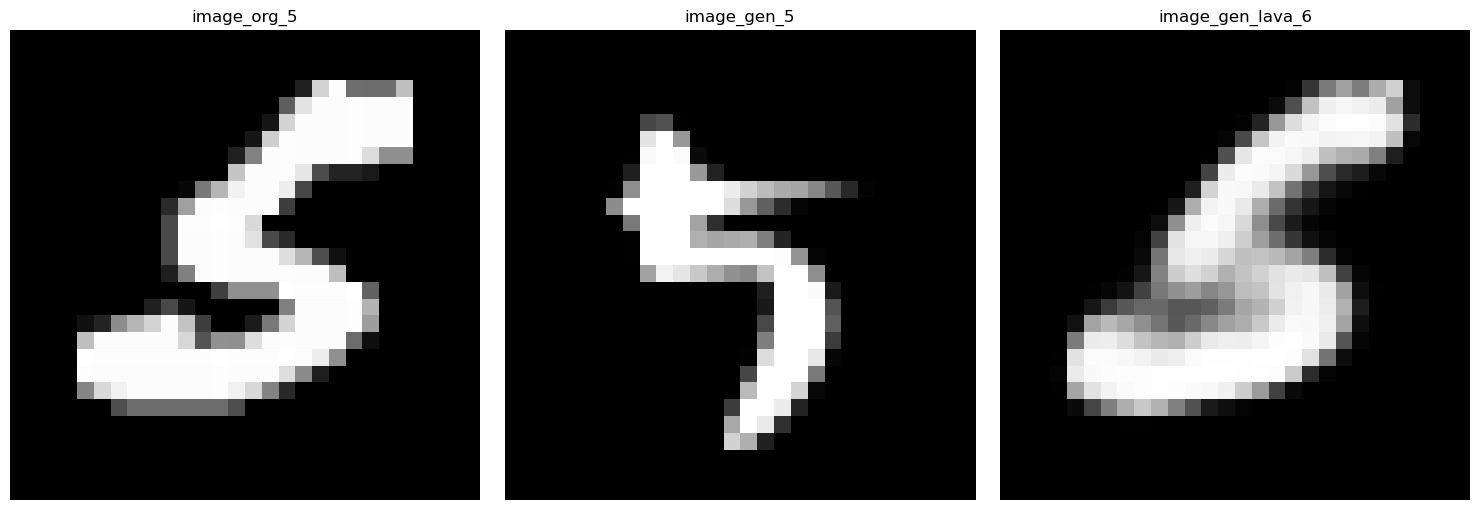

kl_fuzz: 0.6416053771972656
kl_lava: 0.13245031237602234
ws_fuzz: 0.0008868791381905329
ws_lava: 0.00017479572823771362
1/1 [==============================] - 0s 26ms/step
Misclassification achieved at iteration 0,  inner iteration 0
1/1 [==============================] - 0s 24ms/step


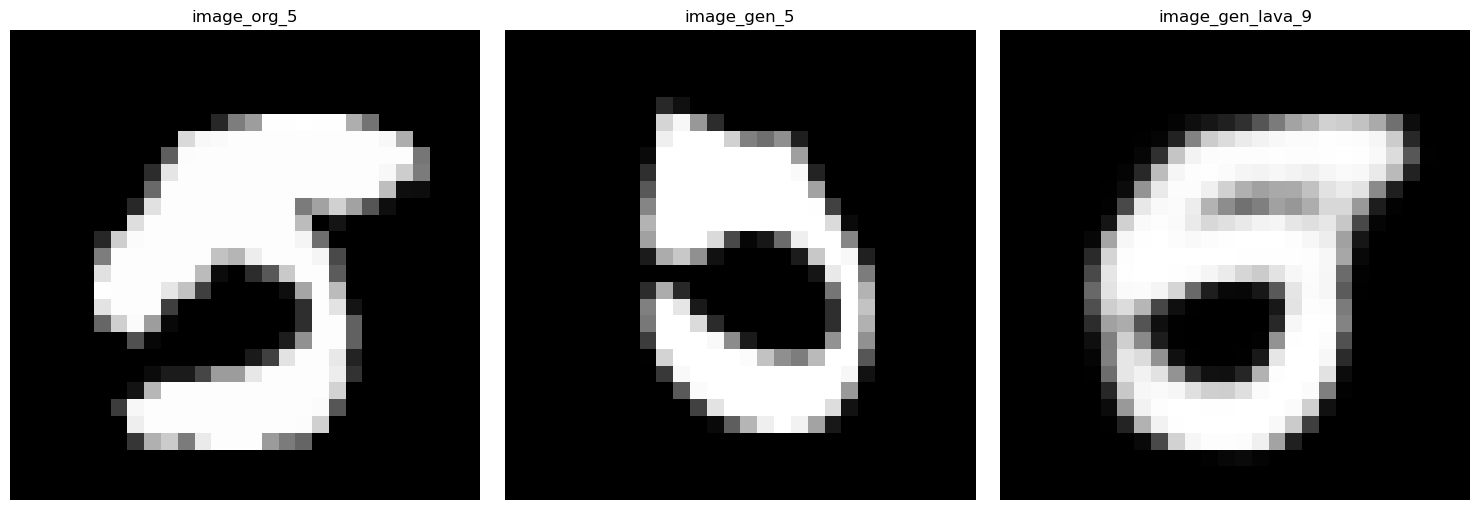

kl_fuzz: 0.45104658603668213
kl_lava: 0.17562051117420197
ws_fuzz: 0.0006282532033820848
ws_lava: 0.00013334630766114648
1/1 [==============================] - 0s 26ms/step
Misclassification achieved at iteration 0,  inner iteration 0
1/1 [==============================] - 0s 25ms/step


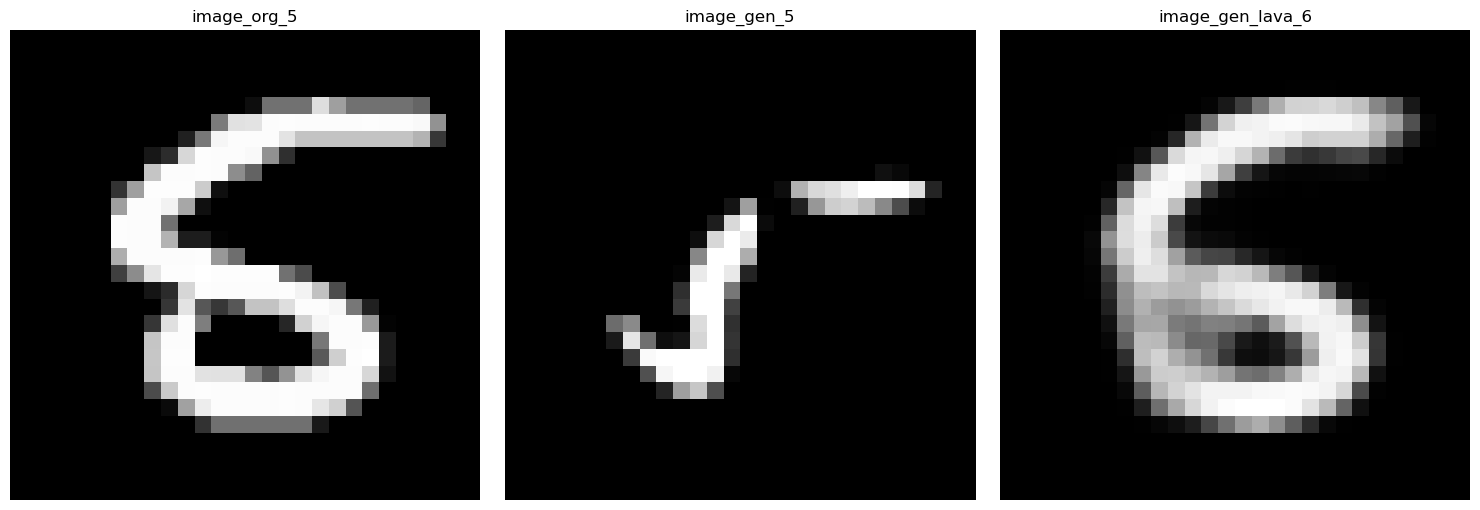

kl_fuzz: 1.3904728889465332
kl_lava: 0.1524011492729187
ws_fuzz: 0.001482059848132515
ws_lava: 0.0002298636891414345
1/1 [==============================] - 0s 28ms/step
Misclassification achieved at iteration 0,  inner iteration 2
1/1 [==============================] - 0s 28ms/step


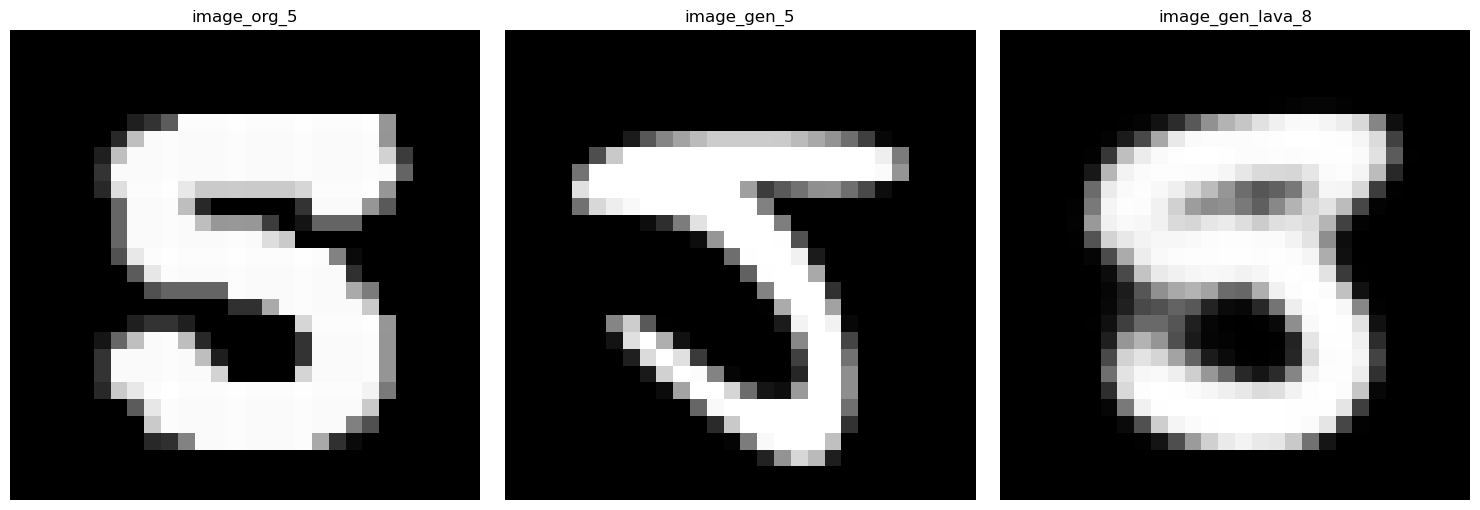

kl_fuzz: 0.3149740695953369
kl_lava: 0.1363663524389267
ws_fuzz: 0.0007438361929101176
ws_lava: 9.009225109620872e-05
1/1 [==============================] - 0s 18ms/step
Misclassification achieved at iteration 39,  inner iteration 44
1/1 [==============================] - 0s 19ms/step


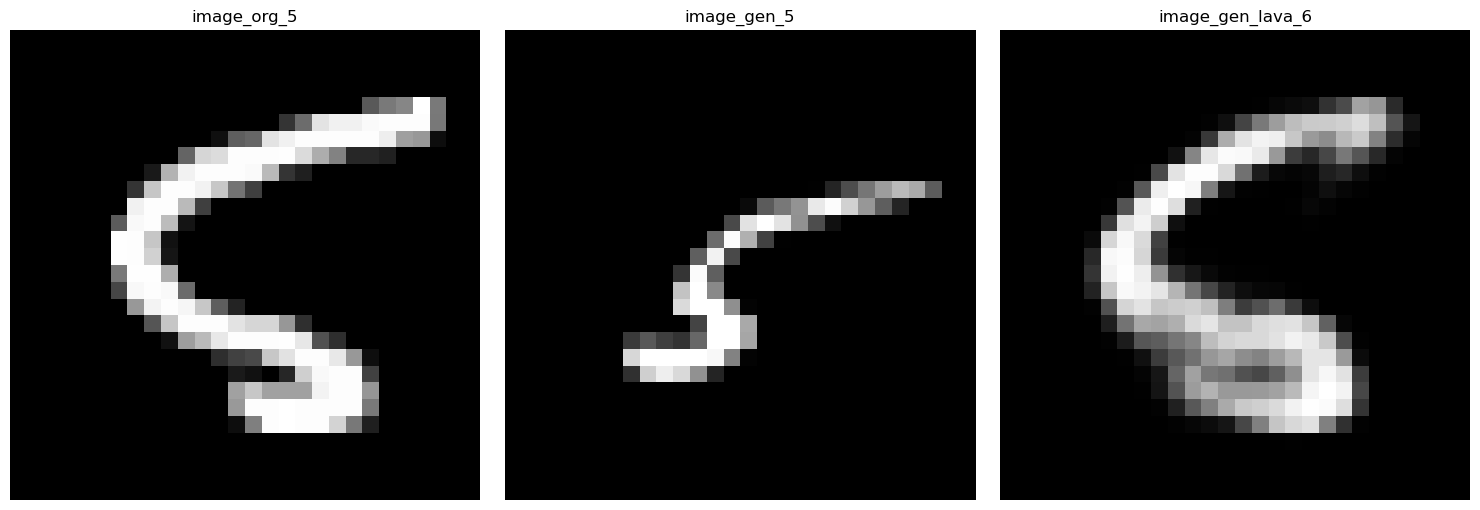

kl_fuzz: 1.471211314201355
kl_lava: 0.42267370223999023
ws_fuzz: 0.0012100421722143252
ws_lava: 0.00023838687452749506
1/1 [==============================] - 0s 19ms/step
Misclassification achieved at iteration 63,  inner iteration 15
1/1 [==============================] - 0s 19ms/step


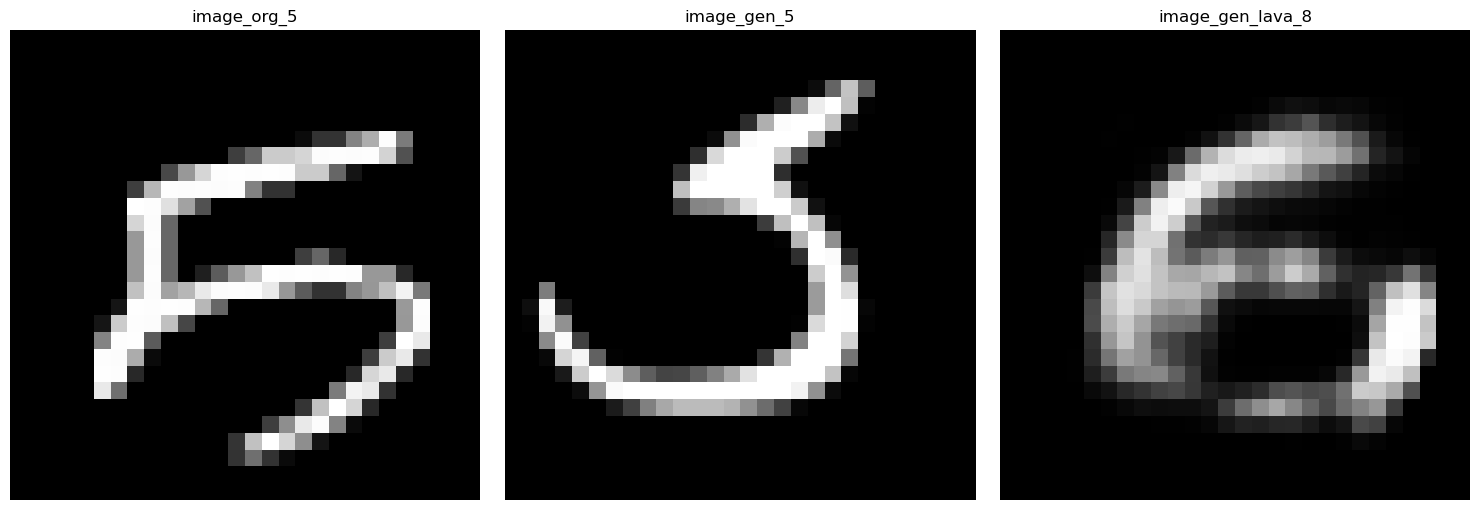

kl_fuzz: 1.654374122619629
kl_lava: inf
ws_fuzz: 9.118823698149849e-05
ws_lava: 0.0004957371516530674
1/1 [==============================] - 0s 20ms/step
Misclassification achieved at iteration 4,  inner iteration 29
1/1 [==============================] - 0s 19ms/step


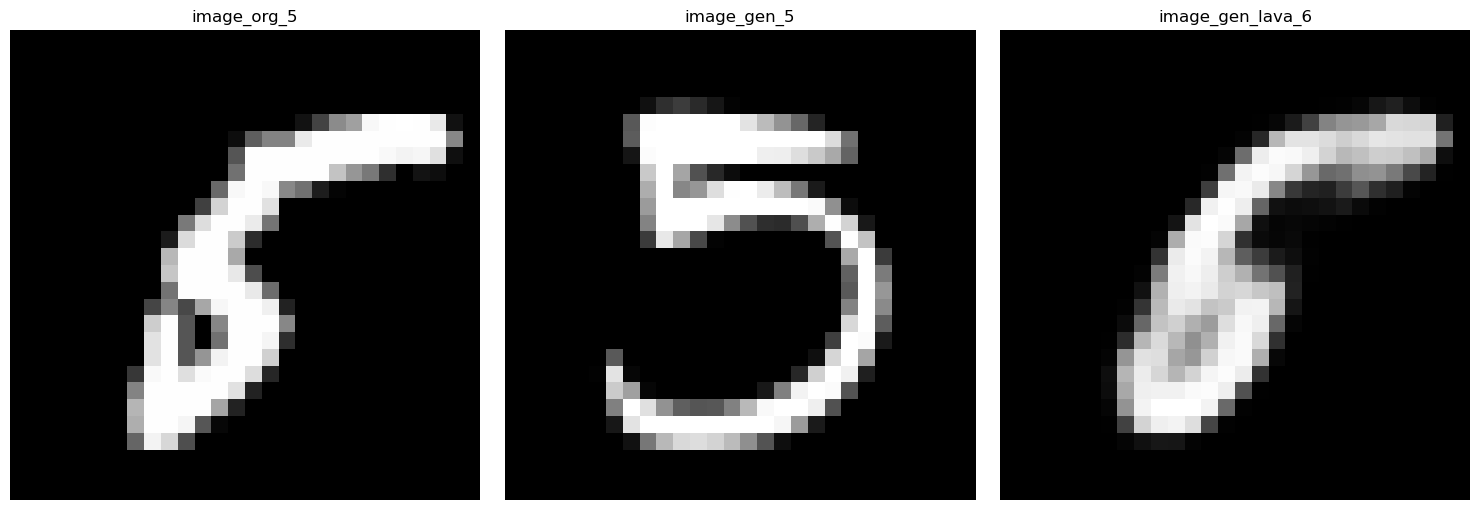

kl_fuzz: 1.3772594928741455
kl_lava: 0.1653631329536438
ws_fuzz: 6.893533276413618e-05
ws_lava: 0.00014725689134279085
1/1 [==============================] - 0s 20ms/step
Misclassification achieved at iteration 1,  inner iteration 6
1/1 [==============================] - 0s 19ms/step


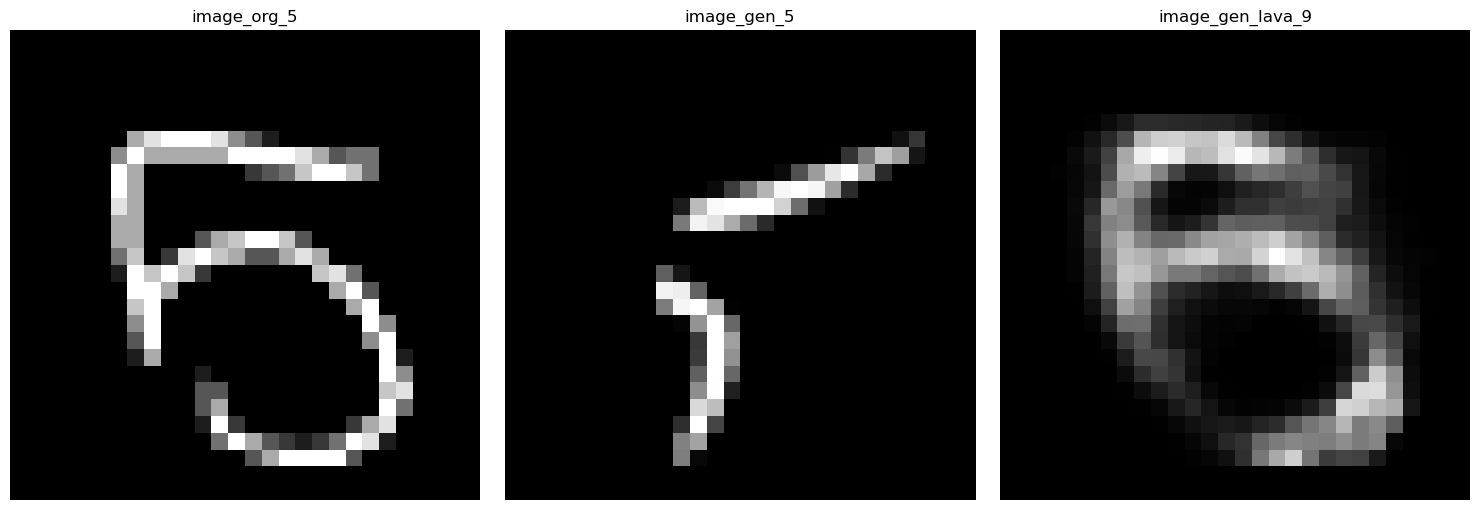

kl_fuzz: 1.876525640487671
kl_lava: inf
ws_fuzz: 0.0009077478523568987
ws_lava: 0.0007222644622153106
1/1 [==============================] - 0s 18ms/step
Misclassification achieved at iteration 63,  inner iteration 5
1/1 [==============================] - 0s 20ms/step


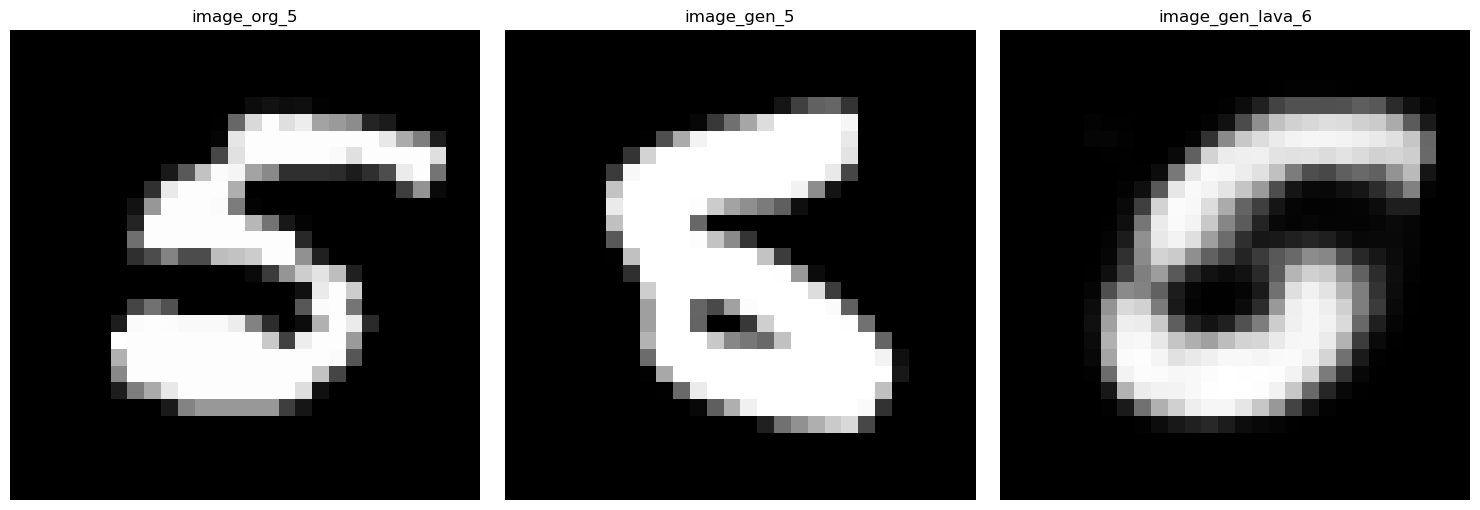

kl_fuzz: 0.6181958913803101
kl_lava: 0.28801560401916504
ws_fuzz: 0.00043983027675104883
ws_lava: 0.00032146692287408446
1/1 [==============================] - 0s 18ms/step
Misclassification achieved at iteration 25,  inner iteration 46
1/1 [==============================] - 0s 19ms/step


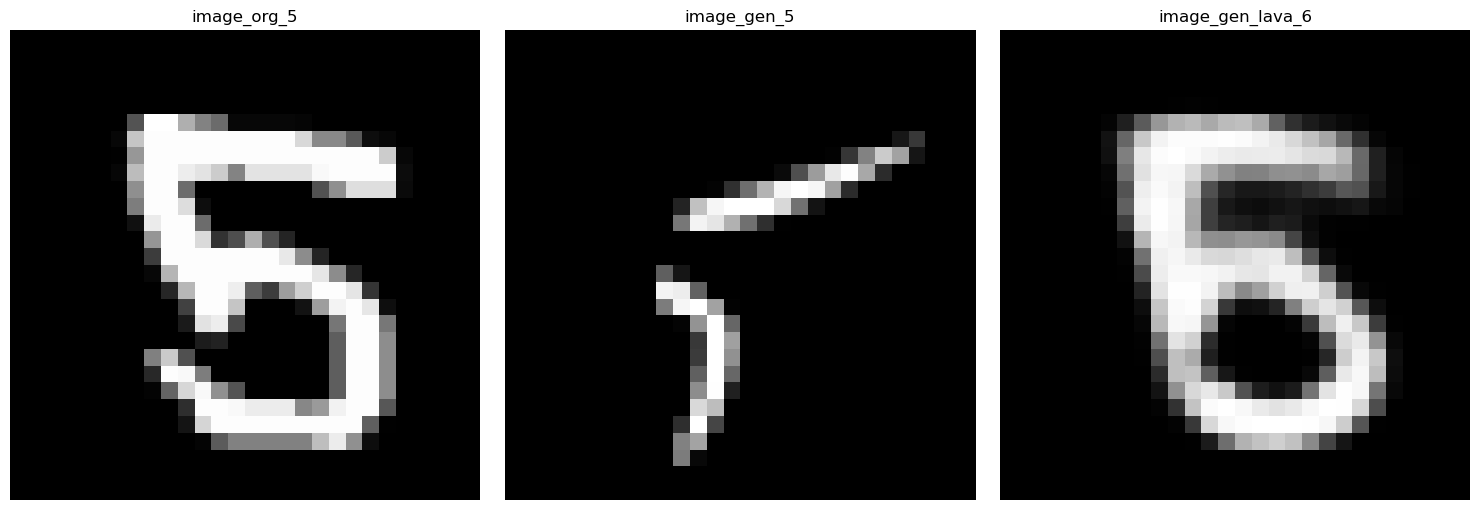

kl_fuzz: 1.162614107131958
kl_lava: 0.22282615303993225
ws_fuzz: 0.0014942255135319638
ws_lava: 0.0001679848263435088
1/1 [==============================] - 0s 19ms/step
Misclassification achieved at iteration 33,  inner iteration 19
1/1 [==============================] - 0s 19ms/step


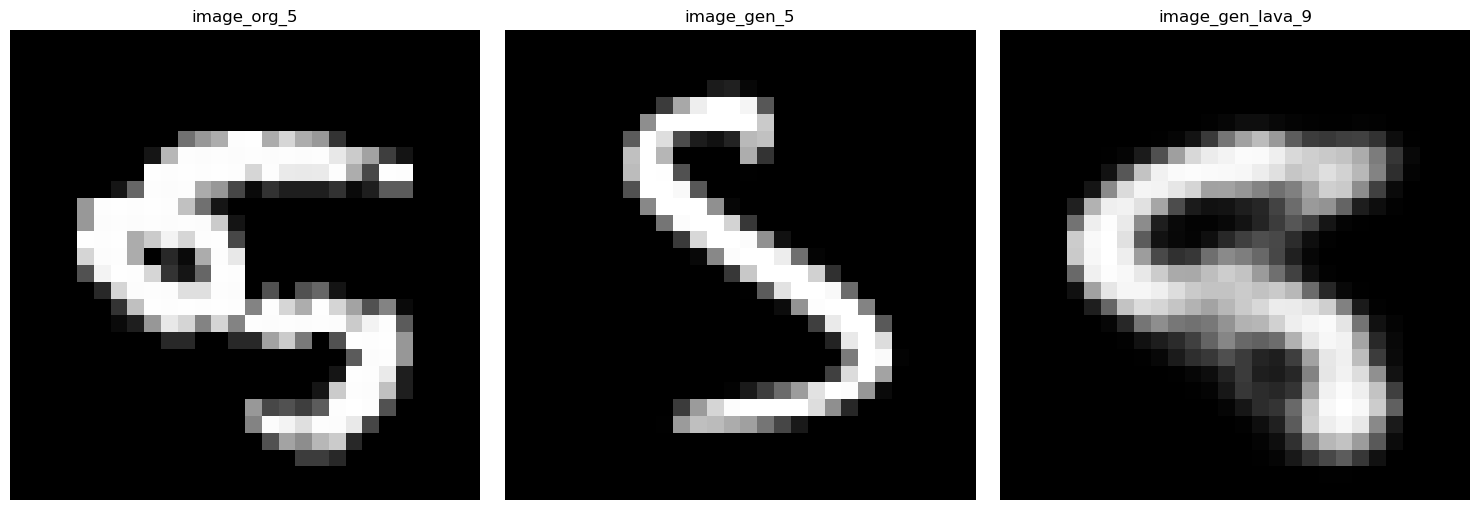

kl_fuzz: 0.9347426891326904
kl_lava: 0.49614542722702026
ws_fuzz: 0.0007172418317799272
ws_lava: 0.000257962093972896
1/1 [==============================] - 0s 19ms/step
Misclassification achieved at iteration 8,  inner iteration 45
1/1 [==============================] - 0s 20ms/step


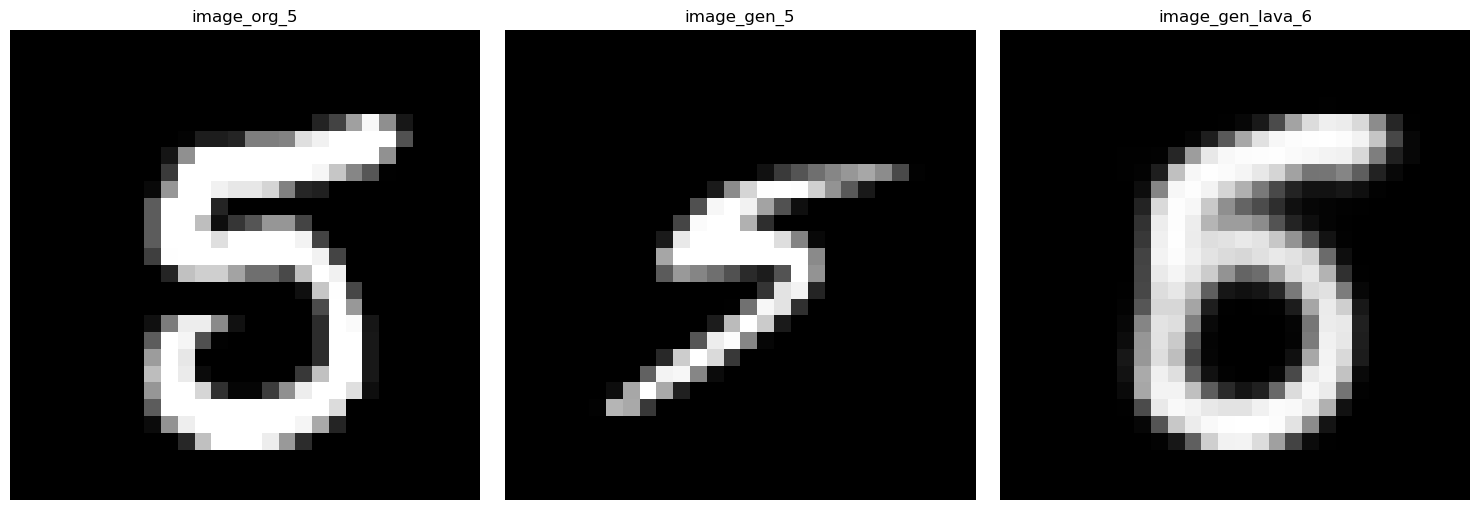

kl_fuzz: 0.6873173713684082
kl_lava: 0.1523430347442627
ws_fuzz: 0.001056136391043208
ws_lava: 0.0002317154175436926
1/1 [==============================] - 0s 18ms/step
Misclassification achieved at iteration 10,  inner iteration 34
1/1 [==============================] - 0s 18ms/step


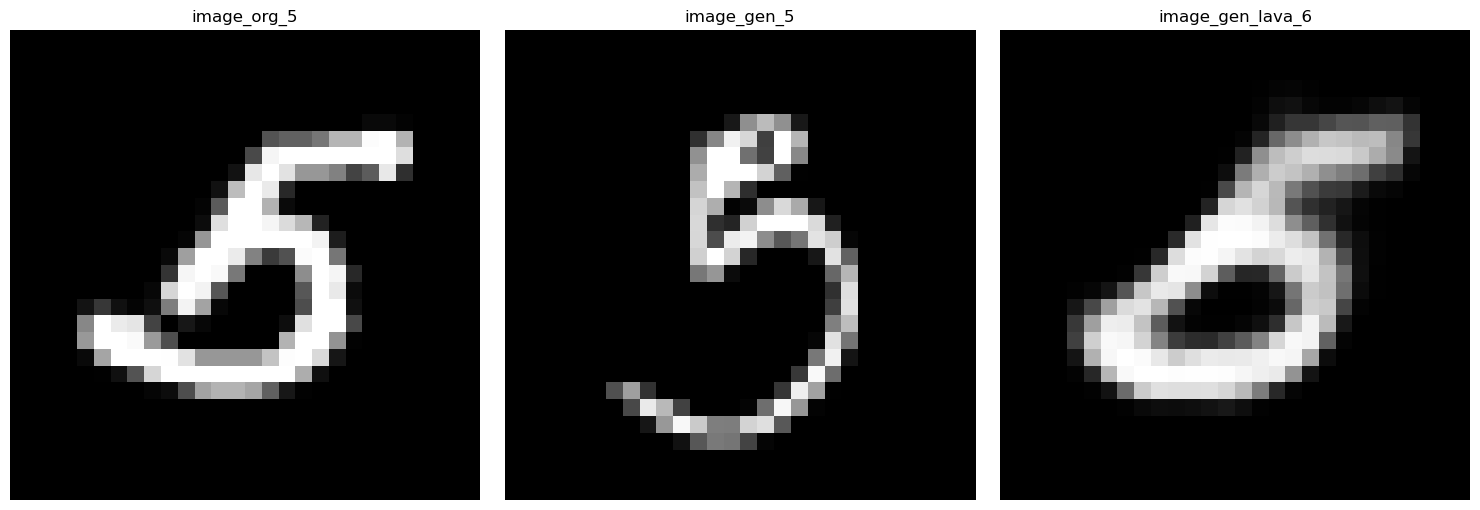

kl_fuzz: 1.2461862564086914
kl_lava: 0.23213255405426025
ws_fuzz: 0.0005428404098280707
ws_lava: 0.0003540721717676398
1/1 [==============================] - 0s 46ms/step
Misclassification achieved at iteration 1,  inner iteration 37
1/1 [==============================] - 0s 19ms/step


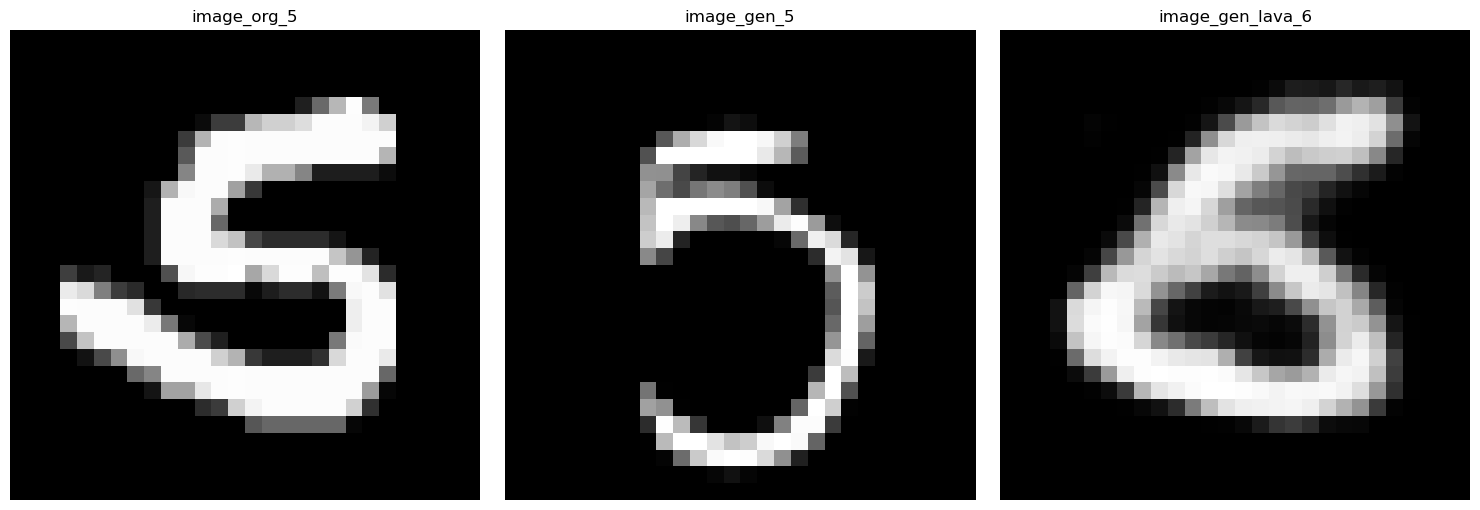

kl_fuzz: 0.8369467258453369
kl_lava: 0.3040008544921875
ws_fuzz: 0.0009193442261694515
ws_lava: 0.00031214627625110713
1/1 [==============================] - 0s 17ms/step
Misclassification achieved at iteration 0,  inner iteration 0
1/1 [==============================] - 0s 18ms/step


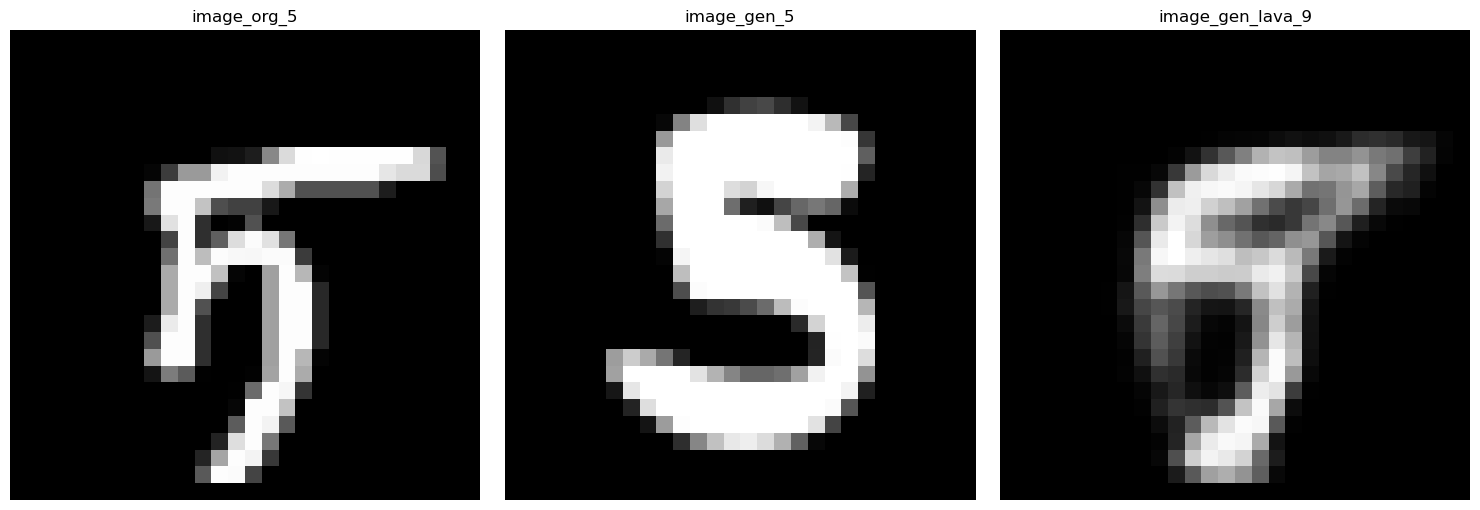

kl_fuzz: 0.9010533690452576
kl_lava: 0.35807323455810547
ws_fuzz: 0.0008362872262416797
ws_lava: 0.00038631182211833534
1/1 [==============================] - 0s 20ms/step
Misclassification achieved at iteration 0,  inner iteration 34
1/1 [==============================] - 0s 21ms/step


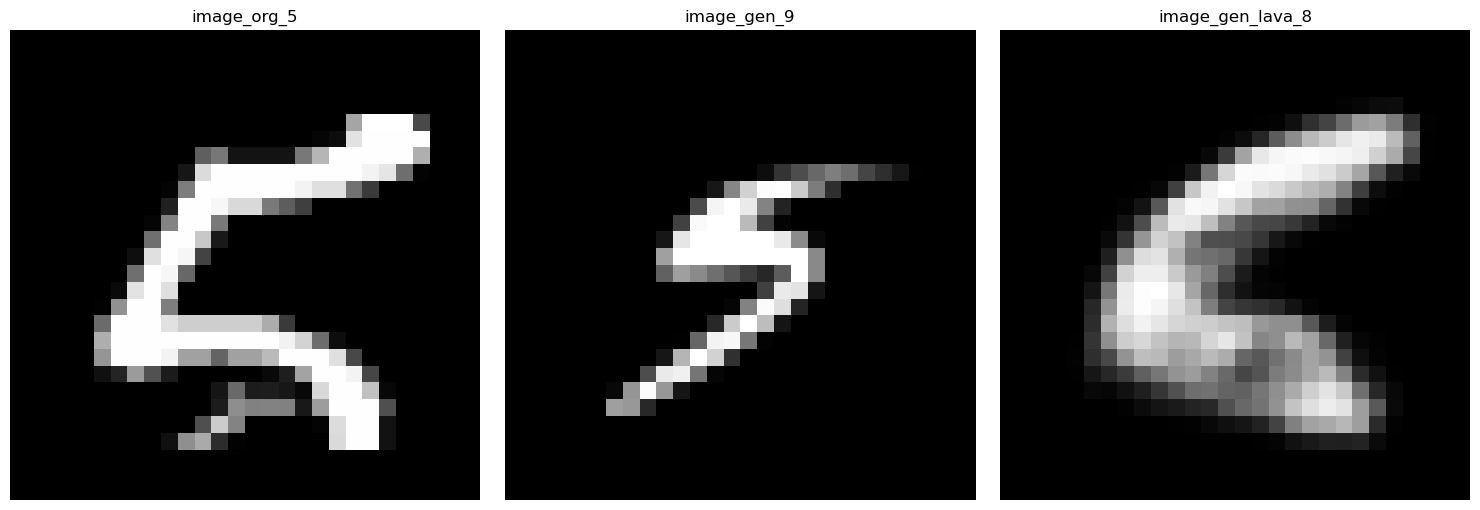

kl_fuzz: 1.157039999961853
kl_lava: 0.46305838227272034
ws_fuzz: 0.0009960316387874553
ws_lava: 0.0004075409757225637
1/1 [==============================] - 0s 21ms/step
Misclassification achieved at iteration 0,  inner iteration 0
1/1 [==============================] - 0s 21ms/step


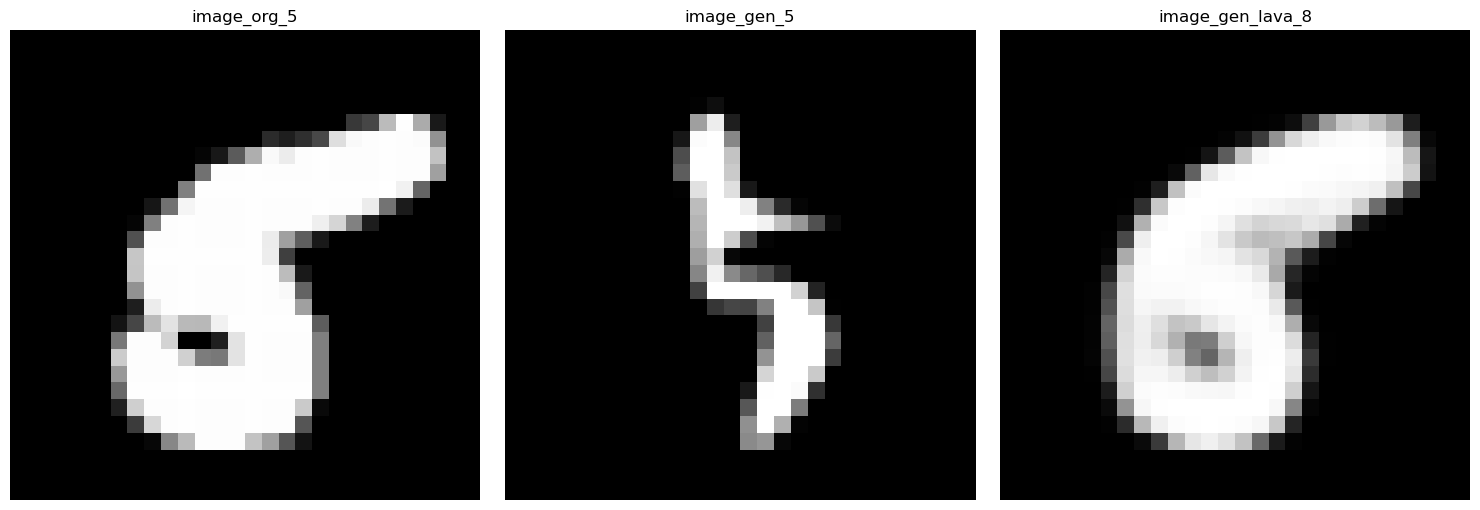

kl_fuzz: 0.4433688223361969
kl_lava: 0.07831409573554993
ws_fuzz: 0.001453054306680036
ws_lava: 5.947359770475789e-05
1/1 [==============================] - 0s 21ms/step
Misclassification achieved at iteration 0,  inner iteration 52
1/1 [==============================] - 0s 21ms/step


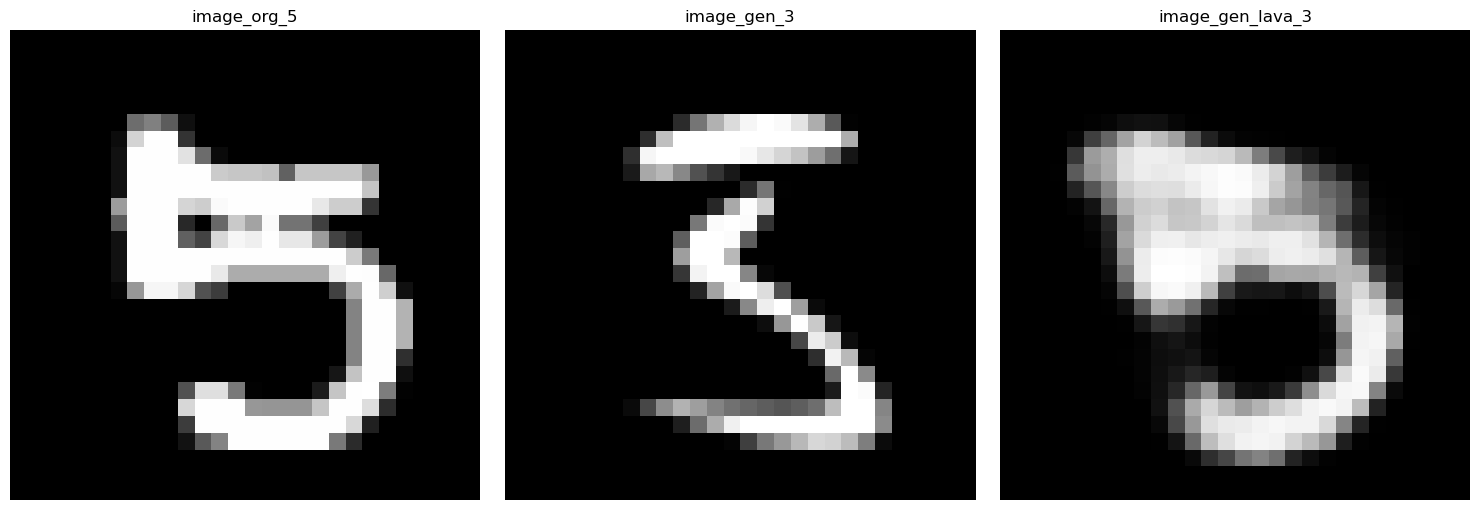

kl_fuzz: 0.917012095451355
kl_lava: 0.2060135453939438
ws_fuzz: 0.0006817781152685897
ws_lava: 0.0002524945876459512
1/1 [==============================] - 0s 20ms/step
Misclassification achieved at iteration 0,  inner iteration 28
1/1 [==============================] - 0s 18ms/step


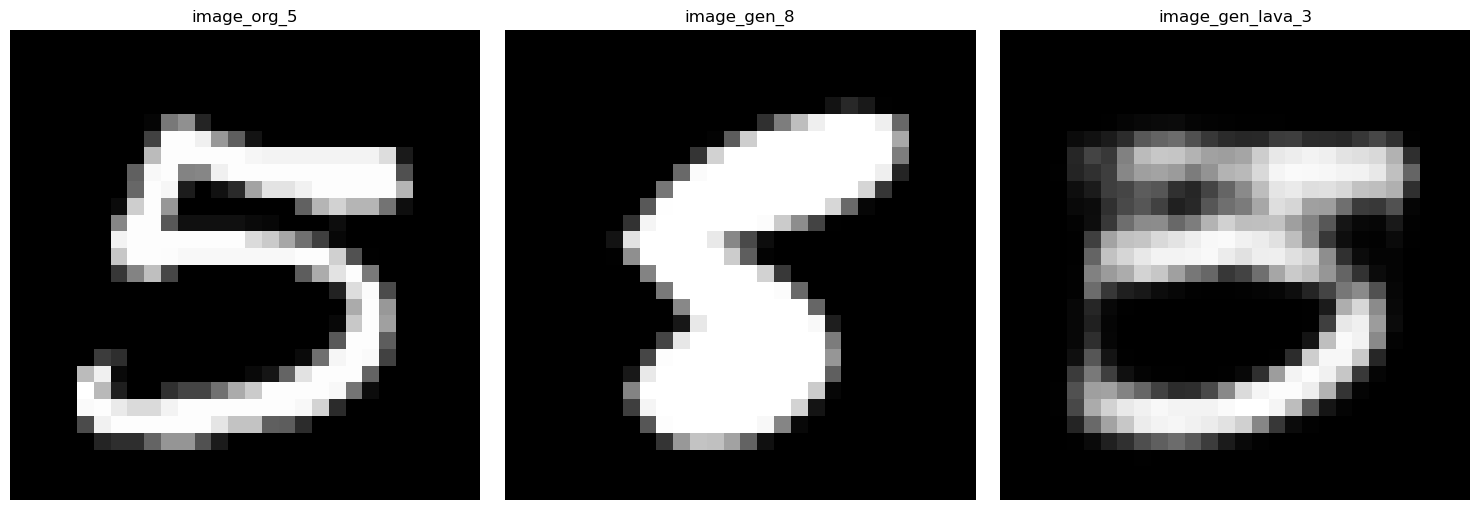

kl_fuzz: 0.9681980609893799
kl_lava: 0.2520934045314789
ws_fuzz: 0.0003840851540078393
ws_lava: 0.00031285404833229774
1/1 [==============================] - 0s 20ms/step
Misclassification achieved at iteration 59,  inner iteration 2
1/1 [==============================] - 0s 21ms/step


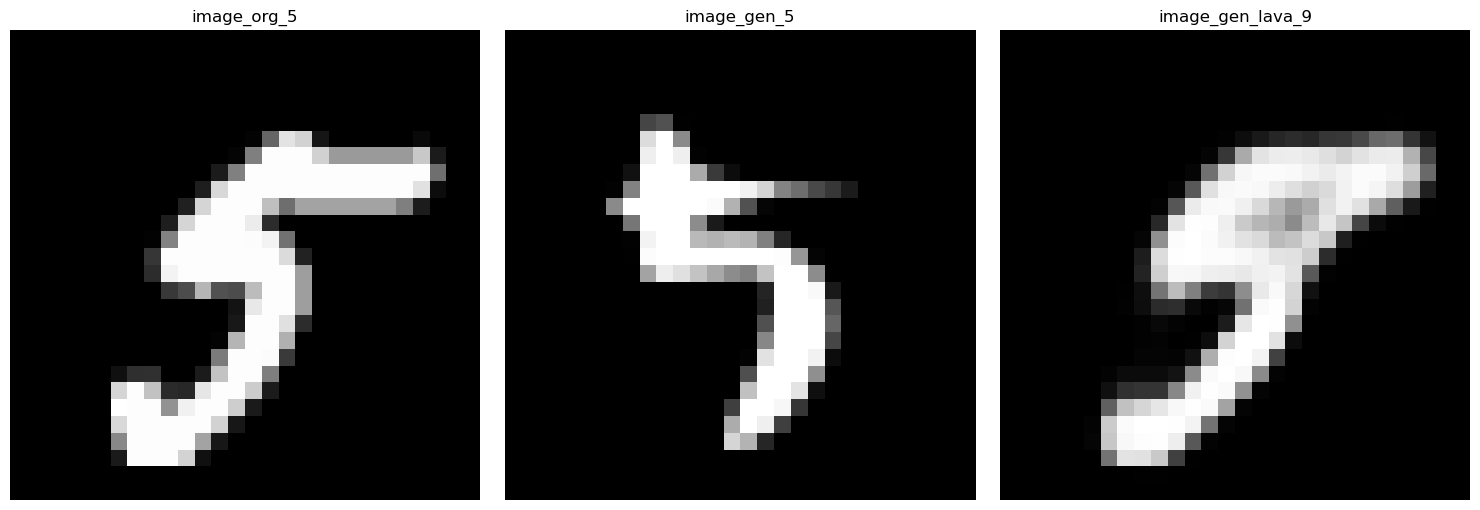

kl_fuzz: 0.9558854699134827
kl_lava: 0.16452357172966003
ws_fuzz: 0.0005567121276114022
ws_lava: 0.00019046968365182165
1/1 [==============================] - 0s 19ms/step
Misclassification achieved at iteration 1,  inner iteration 8
1/1 [==============================] - 0s 19ms/step


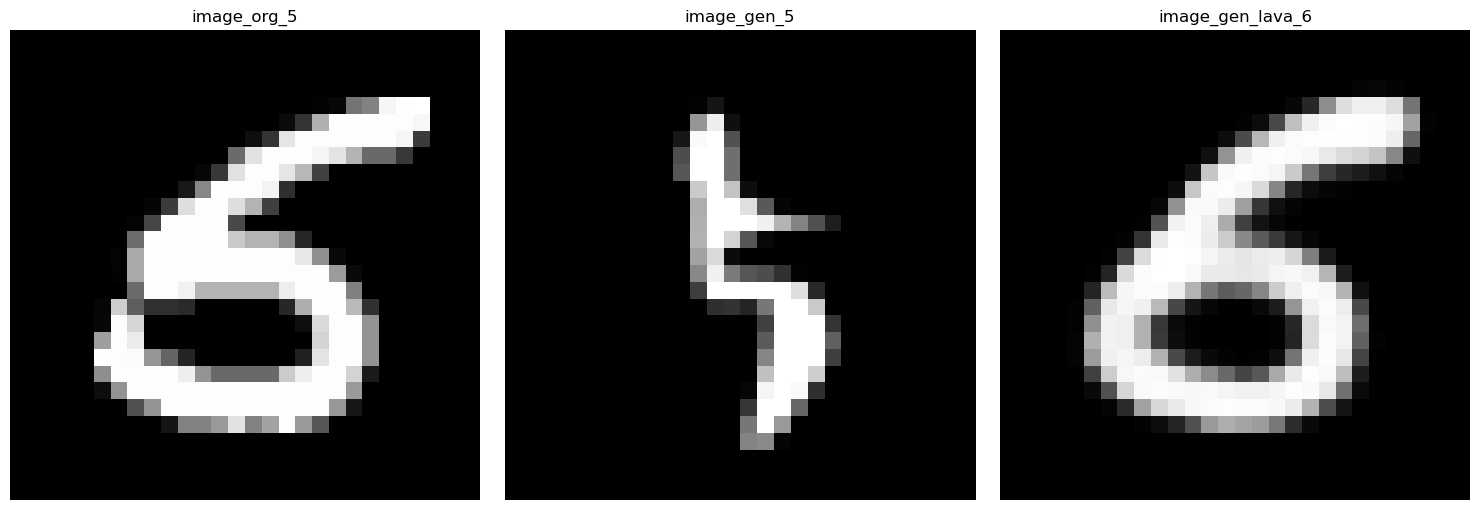

kl_fuzz: 0.9008001685142517
kl_lava: 0.11199820786714554
ws_fuzz: 0.0012246394293961944
ws_lava: 0.00010251720469101932
1/1 [==============================] - 0s 19ms/step
Misclassification achieved at iteration 2,  inner iteration 11
1/1 [==============================] - 0s 19ms/step


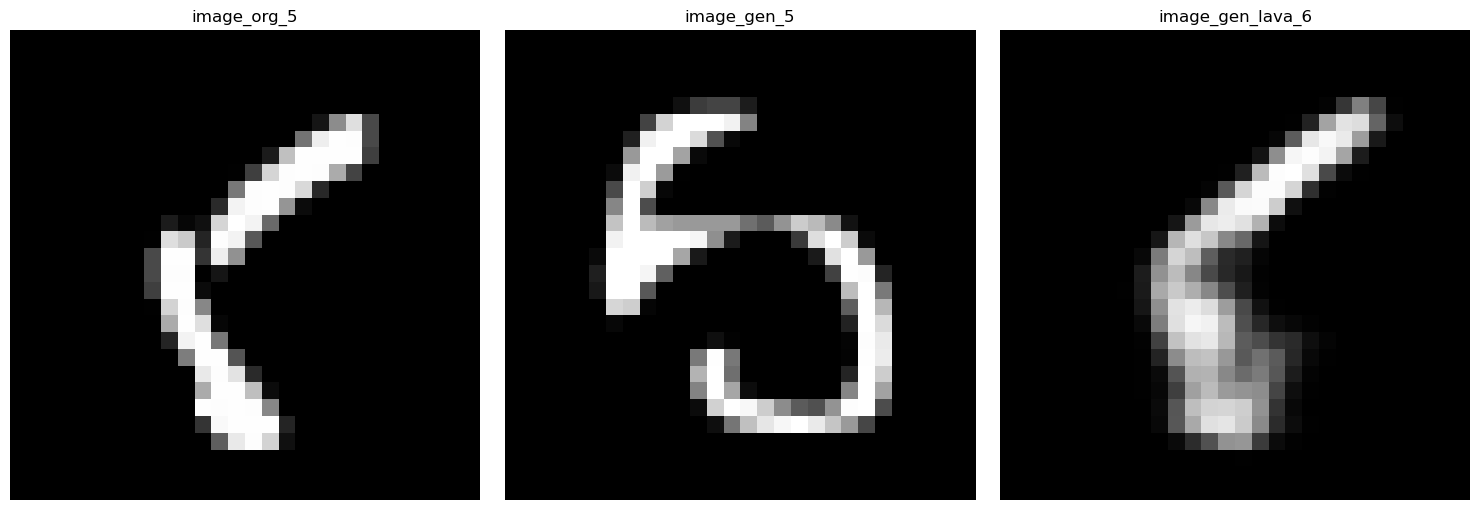

kl_fuzz: 1.7106618881225586
kl_lava: 0.3362266421318054
ws_fuzz: 0.0005015093277933727
ws_lava: 0.00046946572760554474
1/1 [==============================] - 0s 23ms/step
Misclassification achieved at iteration 3,  inner iteration 13
1/1 [==============================] - 0s 22ms/step


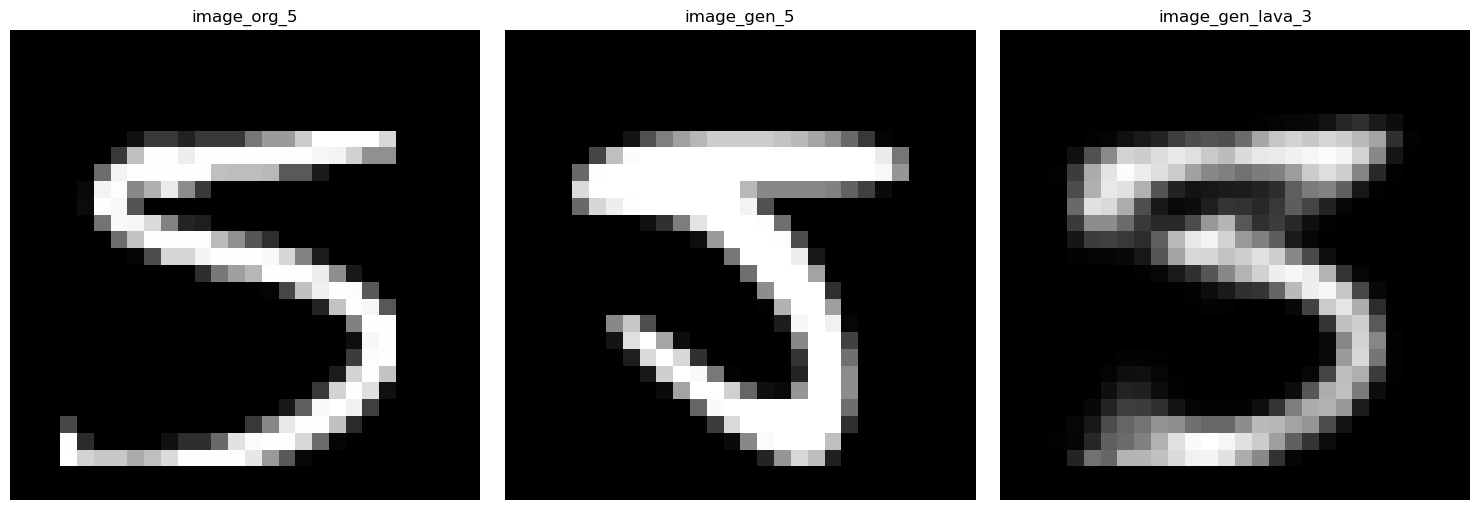

kl_fuzz: 0.8017610907554626
kl_lava: 0.4757055640220642
ws_fuzz: 0.0003749349697203315
ws_lava: 0.0003881707119895699
1/1 [==============================] - 0s 19ms/step
Misclassification achieved at iteration 11,  inner iteration 9
1/1 [==============================] - 0s 20ms/step


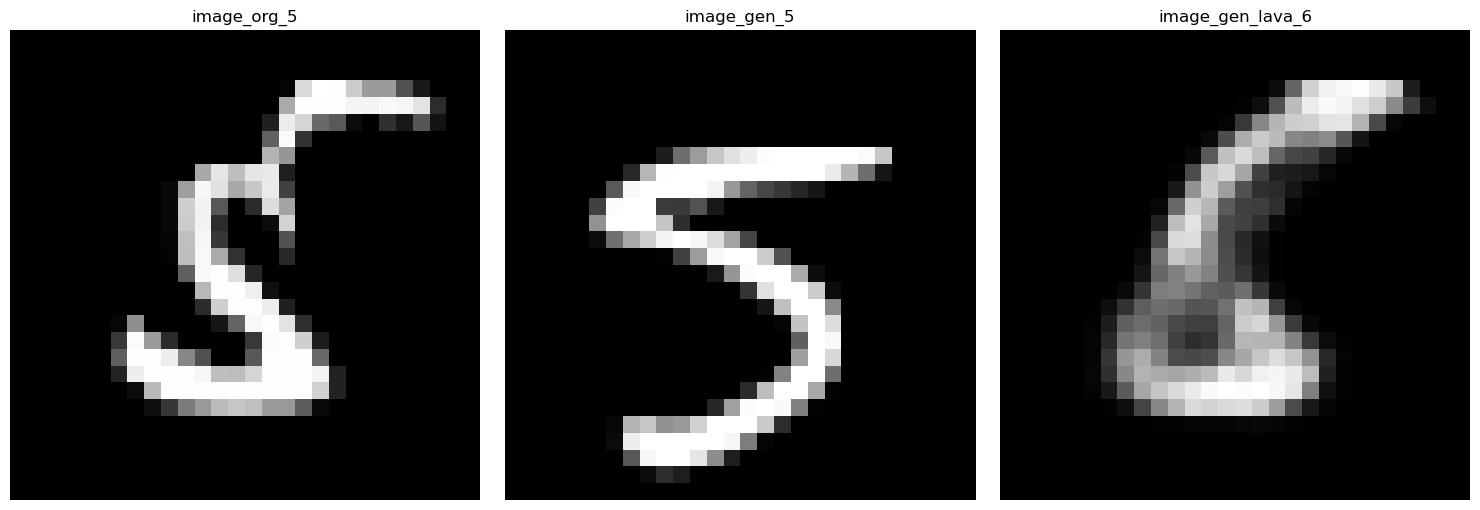

kl_fuzz: 1.5158493518829346
kl_lava: 0.35205212235450745
ws_fuzz: 7.128489568347099e-05
ws_lava: 0.00038140933350580883
1/1 [==============================] - 0s 19ms/step
Misclassification achieved at iteration 3,  inner iteration 49
1/1 [==============================] - 0s 19ms/step


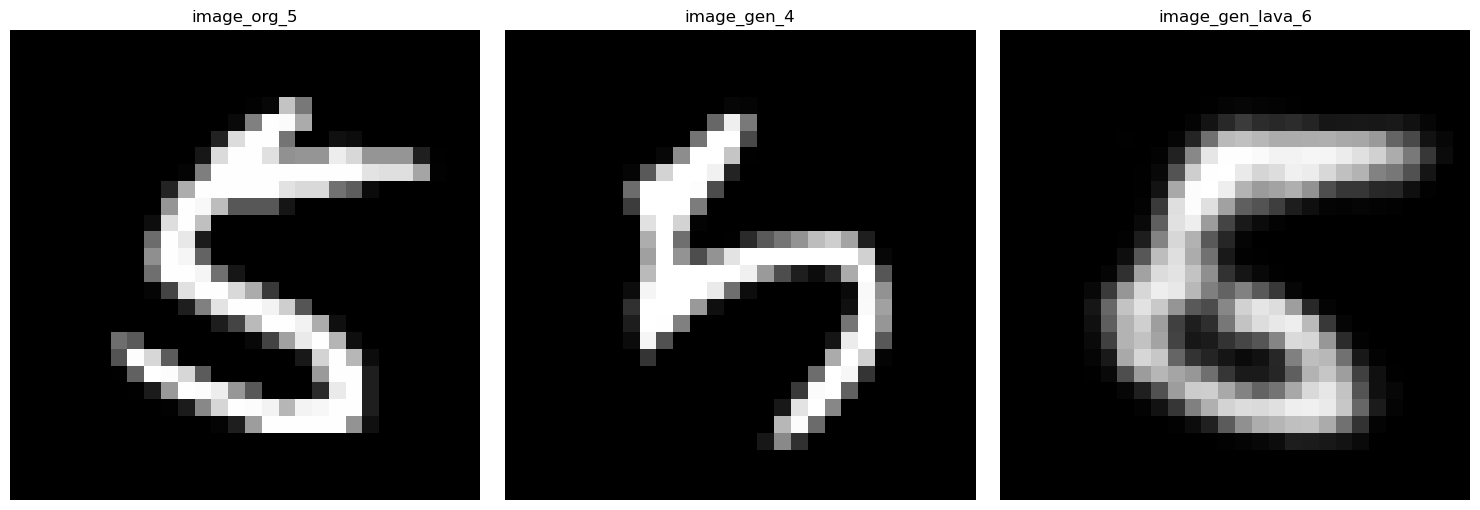

kl_fuzz: 1.108238697052002
kl_lava: 0.3568704128265381
ws_fuzz: 0.00038185962506183705
ws_lava: 0.00046052533976801135
1/1 [==============================] - 0s 28ms/step


In [ ]:
for i in tqdm(range(len(x_view))):

    # calculate fuzz image
    image_org = samples_view[i]
    image_gen = samples_gen[i]

    label_org = sample_labels_view[i]
    # calculate latent variant image
    #image_gen_lava, _ = generate_adversarial_lava(h_view[i], y_onehot_view[i], vae, xai)
    #image_gen_lava, _ = generate_adversarial_lava_step_by_step(h_view[i], y_onehot_view[i], vae, xai, cnn)
    image_gen_lava, _ = generate_adversarial_with_gradient_descent(h_view[i], y_onehot_view[i], 0.01, 100)

    label_gen = np.argmax(cnn.predict(np.array([image_gen]))[0])
    label_lava = np.argmax(cnn.predict(np.array([image_gen_lava]))[0])

    # List of images and their titles
    images = [image_org, image_gen, image_gen_lava]
    titles = [f'image_org_{label_org}', f'image_gen_{label_gen}', f'image_gen_lava_{label_lava}']

    # Plot the images
    if label_lava != label_org:
        plot_image_comparison(images, titles)

        # in image space
        kl_fuzz = kl_divergence(image_org, image_gen)
        kl_lava = kl_divergence(image_org, image_gen_lava)
        print(f"kl_fuzz: {kl_fuzz}\nkl_lava: {kl_lava}")

        ws_fuzz = ws_distance(image_org, image_gen)
        ws_lava = ws_distance(image_org, image_gen_lava)
        print(f"ws_fuzz: {ws_fuzz}\nws_lava: {ws_lava}")
